In [7]:
# Import installed modules
import numpy as np
import pandas as pd
import spiceypy as sp
from astropy.time import Time
from matplotlib import pyplot as plt
from astropy import units as u

# Load the SPICE kernel meta file
sp.furnsh('kernel_meta.txt')

# Dictionary that contains the A and B constants, depending on the index / version
A_FACTOR = {1: -3.33, 2: -1.87}
B_FACTOR = {1: 0.63, 2: 1.22}


def phi_func(index, alpha):
    """
    Phase function that is needed for the reduced magnitude.

    Parameters
    ----------
    index : int
        Phase function index / version. 1 or 2.
    alpha : float
        Phase angle of the asteroid in radians.

    Returns
    -------
    phi : float
        Phase function result.

    """
    return np.exp(A_FACTOR[index] * ((np.tan(alpha/2)) ** B_FACTOR[index]))


def red_mag(abs_mag, alpha, gpar):
    """
    Reduced magnitude of an asteroid, depending on the absolute magnitude,
    phase angle and slope parameter (G)

    Parameters
    ----------
    abs_mag : float
        Absolute magnitude.
    alpha : float
        Phase angle in radians.
    gpar : float
        Slope parameter (G), between 0 and 1.

    Returns
    -------
    r_mag : float
        Reduced magnitude.

    """
    # Computation of the reduced magnitude
    return abs_mag - 2.5*np.log10((1.0 - gpar) * phi_func(1, alpha) + gpar * phi_func(2, alpha))


def app_mag(abs_mag, alpha, gpar, r_sun, r_obs):
    """
    Apparent / Visual magnitude of an asteroid (not considering atmospheric
    attenuation), depending on the absolute magnitude, phase angle, the slope
    parameter (G) as well as the distance between the asteroid and Earth,
    respectively the Sun

    Parameters
    ----------
    abs_mag : float
        Absolute magnitude.
    alpha : float
        Phase angle in radians.
    gpar : float
        Slope parameter (G).
    r_sun : float
        Distance between the asteroid and the Sun in AU.
    r_obs : float
        Distance between the asteroid and the Earth in AU.

    Returns
    -------
    mag : float
        Apparent / visual magnitude.

    """
    return red_mag(abs_mag, alpha, gpar) + 5.0 * np.log10(r_sun * r_obs)

In [23]:
# Set the Ceres NAIF ID
# Get the absolute magnitude and slope parameter (G) from NASA's small body database
# https://ssd.jpl.nasa.gov/sbdb.cgi#top
CERES = dict(id=2000001, hmag=3.4, gpar=0.12)

T1 = Time('2020-01-01T00:00:00', format='isot', scale='utc')
T2 = Time('2020-12-31T00:00:00', format='isot', scale='utc')
times_utc = Time(np.arange(T1, T2, 7*u.day))
times_et = [sp.str2et(_t.strftime('%Y-%m-%dT%H:%M:%S')) for _t in times_utc]

vec_sun = np.array(
    [sp.spkgps(targ=CERES['id'], et=_t, ref='ECLIPJ2000', obs=10)[0]
     for _t in times_et]
)
vec_obs = np.array(
    [sp.spkgps(targ=CERES['id'], et=_t, ref='ECLIPJ2000', obs=399)[0]
     for _t in times_et]
)

_vec_sun_ecl = np.array([sp.recrad(_v) for _v in vec_obs])
ecl_lon = _vec_sun_ecl[:, 1]
ecl_lat = _vec_sun_ecl[:, 2]

r_sun = np.array([sp.convrt(sp.vnorm(_v), 'km', 'AU') for _v in vec_sun])
r_obs = np.array([sp.convrt(sp.vnorm(_v), 'km', 'AU') for _v in vec_obs])
alpha = np.array([sp.vsep(_v1, _v2) for _v1, _v2 in zip(vec_sun, vec_obs)])
# otherwise,
# sp.phaseq(et=x, target=str(CERES["id"]), illmn='10', obsrvr='399', abcorr='NONE'))
alpha_deg = np.rad2deg(alpha)
vmag = app_mag(CERES['hmag'], alpha, CERES['gpar'], r_sun, r_obs)

/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_44301/3710390569.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Reds_r')


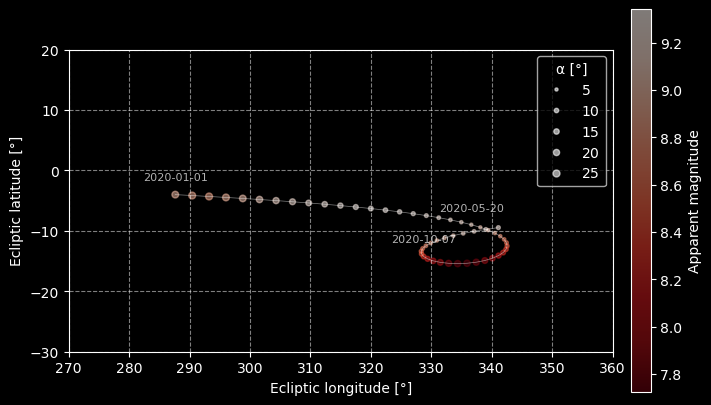

In [71]:
# What do we want to achieve? Well a sky plot with the path of Ceres would be
# nice. Scaling and colouring the individual positions based on the apparent
# magnitude would guide the eye. Remember: a smaller magnitude corresponds to a
# brighter object. Scaling a bright object smaller would be kind of
# contra-intuitive.
mksize = -(alpha - np.min(alpha)) / np.ptp(alpha) * 20 + 25

plt.style.use('dark_background')
fig, axs = plt.subplots(1, 1, figsize=(7, 4), layout="constrained", sharex=False, sharey=False, gridspec_kw=None)

ax = axs
cm = plt.cm.get_cmap('Reds_r')
sc = ax.scatter(x=np.rad2deg(ecl_lon), y=np.rad2deg(ecl_lat), c=vmag, s=mksize, cmap=cm, alpha=0.5)
ax.plot(np.rad2deg(ecl_lon), np.rad2deg(ecl_lat), color='white', alpha=0.5, linewidth=0.5)

cbar = fig.colorbar(sc, ax=ax, pad=0.01)
cbar.set_label('Apparent magnitude')

handles, labels = sc.legend_elements(prop="sizes", alpha=0.6, num=5, color="white")
legend2 = ax.legend(handles, labels, loc="upper right", title="α [°]")

# To get a better feeling how Ceres moves along the sky during the year, we
# add some date-time text fields along the path
for i in range(0, len(times_utc), 20):
    _x, _y = np.rad2deg(ecl_lon[i]), np.rad2deg(ecl_lat[i])
    ax.annotate(times_utc[i].strftime('%Y-%m-%d'),
                xy=(_x, _y),
                xycoords='data',
                textcoords='offset points',
                xytext=(0, 10),
                ha='center',
                color='white',
                alpha=0.7,
                fontsize=8
    )

ax.set(xlabel='Ecliptic longitude [°]', ylabel='Ecliptic latitude [°]', ylim=(-30, 20), xlim=(270, 360))
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_aspect('equal')

fig.align_ylabels(axs)
fig.align_xlabels(axs)
plt.show();

# plt.savefig(figoutpath, dpi=300, bbox_inches = "tight")